### 4. <u>Orchestrator-Worker</u>:

In the orchestrator-worker workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMS, and synthesizes their results.

--> **<u>When to use this workflow</u>:**

This workflow is well suited for complex tasks where you can't predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of change in each file likely depend on the task). Whereas its topologically similar, the key difference from parallelization is its flexibility - subtasks are not pre-defined, but determined by the orchestrator based on the specific input.


## Creating a *Report Generator Agent* using Orchestrator-Worker Workflow:
---

In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
if groq_api_key is None:
    raise ValueError("GROQ_API_KEY environment variable is not set")

os.environ["GROQ_API_KEY"] = groq_api_key

llm = ChatGroq(model="openai/gpt-oss-20b")
response = llm.invoke("Hi")
response

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'The user says "Hi". Probably they want a greeting. We should respond politely. No further instructions.'}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 72, 'total_tokens': 112, 'completion_time': 0.04037977, 'prompt_time': 0.003388136, 'queue_time': 0.043087194, 'total_time': 0.043767906}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_c5a89987dc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--760bdad3-412a-448d-b442-8d72d93ac628-0', usage_metadata={'input_tokens': 72, 'output_tokens': 40, 'total_tokens': 112})

In [2]:
from typing import Annotated,List
import operator
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage

In [3]:
class Section(BaseModel):
    name:str=Field(description="Name of this section of the report")
    description:str=Field(description="Brief overview of the main topics and concepts of this section")


class Sections(BaseModel):
    sections:List[Section]=Field(description="List of sections in the report")

plannar = llm.with_structured_output(Sections)

In [4]:
plannar.invoke("Romance Anime")

Sections(sections=[Section(name='Overview', description='A concise introduction to romance anime, covering its origins, core narrative elements, and the emotional appeal that defines the genre.'), Section(name='Popular Titles', description='A curated list of landmark and contemporary romance anime, highlighting their unique storylines and impact on audiences.'), Section(name='Themes & Motifs', description='An exploration of recurring motifs such as first love, forbidden romance, and personal growth, and how they shape character arcs.'), Section(name='Character Archetypes', description='A breakdown of common archetypes—tsundere, shy protagonist, love interest—and how they contribute to storytelling.'), Section(name='Visual & Aesthetic Style', description='An analysis of animation techniques, color palettes, and visual cues that enhance romantic tension and mood.'), Section(name='Soundtrack & Music', description='How composers use melodies, vocal themes, and sound design to underscore em

### Creating Workers Dynamically in LangGraph (Using Send API)

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over A list of sections and Send each to a worker node.

In [5]:
from langgraph.constants import Send

class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_sections: Annotated[list,operator.add]
    final_report:str

class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]


C:\Users\madda\AppData\Local\Temp\ipykernel_2220\1657467006.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [6]:
def orchestrator(state:State):
    """Orchestrator that generates a plan for the report"""

    report_sections = plannar.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report title: {state['topic']}"),
        ]
    )

    print("Report Sections:" , report_sections)
    return {'sections':report_sections.sections}

In [7]:
def llm_call(state:WorkerState):
    """Worker that writes a section of the report"""
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown format"),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"),
        ]
    )
    return {'completed_sections':[section.content]}

In [8]:
# Conditonal edge function to create llm_call workers that each write a section of the report

def assign_workers(state:State):
    """Assign a worker to each section in the plan"""
    return [Send("llm_call",{'section':s}) for s in state['sections']]

In [9]:
def synthesizer(state:State):
    """Synthesizer that combines all sections into a final report"""
    
    completed_sections = state['completed_sections']

    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {'final_report':completed_report_sections}

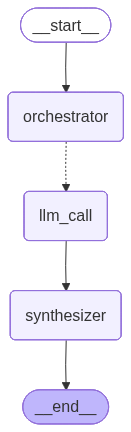

In [10]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image,Markdown

builder = StateGraph(State)

builder.add_node("orchestrator",orchestrator)
builder.add_node("llm_call",llm_call)
builder.add_node("synthesizer",synthesizer)

builder.add_edge(START,"orchestrator")
builder.add_conditional_edges('orchestrator',assign_workers,['llm_call'])
builder.add_edge("llm_call","synthesizer")
builder.add_edge("synthesizer",END)

builder_graph = builder.compile()

display(Image(builder_graph.get_graph().draw_mermaid_png()))

In [ ]:
response = builder_graph.invoke({'topic':"Isekai Anime"})

Markdown(response['final_report'])

Report Sections: sections=[Section(name='Introduction', description='Provide a brief overview of the isekai genre, its origins, and its popularity in anime culture.'), Section(name='Historical Development', description='Trace the evolution of isekai anime from early examples to contemporary series, highlighting key milestones.'), Section(name='Core Themes and Tropes', description='Analyze recurring motifs such as the ‘trading place’ trope, overpowered protagonists, and world-building elements.'), Section(name='Notable Series and Case Studies', description='Present in-depth looks at landmark shows (e.g., *Sword Art Online*, *Re:Zero*, *That Time I Got Reincarnated as a Slime*), discussing plot, characters, and reception.'), Section(name='Cultural Impact and Fan Reception', description='Examine how isekai anime has influenced fan communities, merchandise, and broader media trends.'), Section(name='Critiques and Controversies', description='Address common criticisms (e.g., formulaic story

## Introduction and Description

Isekai, a subgenre of fantasy that translates literally to “another world,” has become a staple of contemporary anime and manga. The core premise involves a protagonist—often a young, relatable figure—being transported, reborn, or trapped in an alternate realm, frequently one that mirrors or expands upon familiar fantasy tropes such as magic, mythical creatures, and medieval societies. 

### Origins
The roots of isekai can be traced back to early Japanese speculative fiction, but it gained distinct identity in the 1990s with works like *The Irresponsible Captain Tylor* (1993) and *The Twelve Kingdoms* (1992). These stories laid the groundwork for the “otherworld” concept, blending adventure with introspective character arcs. In the 2000s, light novels such as *Spice and Wolf* (2001) and *The Rising of the Shield Hero* (2015) further refined the formula, emphasizing world-building and the protagonist’s growth.

### Popularity in Anime Culture
The genre exploded in the 2010s, propelled by titles such as *Sword Art Online* (2012), *Re:Zero* (2016), and *That Time I Got Reincarnated as a Slime* (2018). Several factors fuel its popularity:
- **Escapism**: Viewers seek immersive narratives that offer a departure from everyday life.
- **Relatable Protagonists**: Many protagonists start as ordinary, sometimes flawed, individuals who evolve through extraordinary circumstances.
- **Hybrid Appeal**: Isekai blends high fantasy, action, romance, and sometimes slice-of-life elements, appealing to diverse audiences.
- **Cross-Media Synergy**: Light novels, manga, anime, and games create a multi-platform ecosystem that sustains long-term engagement.

Consequently, isekai has become a dominant force in anime, influencing production trends, marketing strategies, and fan communities worldwide.

---

## Historical Development

- **Early 2000s – Foundations**  
  * *The Twelve Kingdoms* (2002) – Adapted from a manga, it introduced a complex fantasy world with a Japanese protagonist who must navigate political intrigue and magic. Often cited as the first modern isekai anime.  
  * *The World of Narue* (2007) – A light‑novel adaptation that blended adventure with a “trapped in another world” premise, laying groundwork for future adaptations.  

- **2010–2012 – The “Sword Art Online” Effect**  
  * *Sword Art Online* (2012) – A virtual‑reality MMORPG setting that resonated with the rising popularity of online gaming. It broadened the isekai definition to include digital realms and sparked a wave of similar narratives.  
  * *No Game No Life* (2014) – Although released a bit later, it built on the success of SAO by exploring a world governed entirely by games, reinforcing the appeal of alternate rulesets.  

- **Mid‑2010s – Diversification of Tone and Setting**  
  * *KonoSuba: God's Blessing on this Wonderful World!* (2016) – A comedic take on the genre, showing that isekai could thrive with humor and self‑parody.  
  * *Re:Zero – Starting Life in Another World* (2016) – Introduced a darker, psychologically complex narrative, emphasizing the consequences of time loops and failure.  
  * *The Saga of Tanya the Evil* (2017) – Combined isekai with war‑strategy and a gender‑fluid protagonist, illustrating the genre’s flexibility.  

- **Late 2010s – The “Slime” and “Shield Hero” Phenomena**  
  * *That Time I Got Reincarnated as a Slime* (2018) – Popularized the “slime” trope and highlighted the potential for world‑building and economic systems within a fantasy setting.  
  * *The Rising of the Shield Hero* (2019) – Introduced the “betrayed protagonist” narrative, expanding the emotional stakes and exploring themes of redemption and perseverance.  
  * *Mushoku Tensei: Jobless Reincarnation* (2019) – Showcased a more mature, character‑driven approach, blending life‑simulation elements with traditional isekai tropes.  

- **2020s – The Isekai Boom and Meta‑Narratives**  
  * *Isekai Quartet* (2019–present) – A crossover that parodied the genre itself, demonstrating its cultural saturation.  
  * *Over 100% of the series that aired in 2020–2022* – Saw a surge in original anime projects, many of which blended isekai with other genres (slice‑of‑life, horror, psychological thriller).  
  * Streaming platforms (Netflix, Crunchyroll, Amazon Prime) – Their global reach accelerated the spread of isekai, leading to international fanbases and cross‑media adaptations.  

- **Contemporary Trends (2023–2024)**  
  * Continued expansion into “meta‑isekai” and “post‑isekai” narratives, where protagonists return to their original worlds or confront the consequences of their adventures.  
  * Increased focus on world‑building depth, including detailed economies, political structures, and ecological systems.  
  * A growing emphasis on diverse representation, with protagonists of varied backgrounds and identities exploring new worlds.  

**Key Milestones Summary**

| Year | Milestone | Significance |
|------|-----------|--------------|
| 2002 | *The Twelve Kingdoms* | First modern isekai anime; established core tropes. |
| 2012 | *Sword Art Online* | Expanded isekai to virtual realms; sparked global interest. |
| 2016 | *Re:Zero* | Introduced psychological depth and time‑loop mechanics. |
| 2018 | *That Time I Got Reincarnated as a Slime* | Popularized the “slime” trope; highlighted world‑building. |
| 2019 | *The Rising of the Shield Hero* | Brought darker betrayal themes into mainstream. |
| 2020 | Isekai boom | Surge of original content; genre mainstreamed. |
| 2023–24 | Meta‑ and post‑isekai narratives | Reflects genre maturity and audience demand for complexity. |

These milestones chart the genre’s trajectory from niche fantasy adventures to a dominant, multifaceted narrative form that continues to evolve with audience expectations and media platforms.

---

## Core Themes and Tropes

The narrative is built around a handful of recognizable motifs that recur across the series, reinforcing its identity and guiding reader expectations.

### 1. The “Trading Place” Trope  
- **Function**: Serves as the central hub where characters exchange goods, information, and favors, mirroring classic marketplace dynamics found in many fantasy and sci‑fi settings.  
- **Narrative Role**: Acts as a narrative crossroads, allowing disparate plot threads to intersect. It also provides a stable backdrop against which character development unfolds, as interactions within the trading place reveal motivations, alliances, and rivalries.  
- **Cultural Significance**: Reflects the idea of commerce as a social glue, reinforcing themes of interdependence and negotiation.  

### 2. Overpowered Protagonists  
- **Definition**: Main characters frequently possess abilities or resources far exceeding those of surrounding NPCs or even the established limits of the world’s rules.  
- **Implications**:  
  - **Plot Momentum**: Their abilities accelerate conflict resolution, creating a fast-paced narrative that keeps readers engaged.  
  - **Risk of Tension**: The narrative must balance their power with credible obstacles (e.g., moral dilemmas, external constraints, or personal costs) to avoid a deus ex machina feel.  
  - **Thematic Echoes**: The trope often underscores themes of destiny, responsibility, and the ethical use of power.  

### 3. World‑Building Elements  
- **Layered Economies**: The trading place is not just a marketplace but a microcosm of the broader economic system, hinting at supply chains, currency fluctuations, and trade tariffs that influence larger plot arcs.  
- **Cultural Diversity**: The characters and factions represented in the trading place reflect a mosaic of cultures, each with distinct customs, dialects, and technologies, enriching the world’s depth.  
- **Environmental Integration**: The setting’s geography—its climate, resources, and political boundaries—directly affects the availability of goods, the prevalence of certain factions, and the strategic importance of the trading hub.  
- **Technological/ Magical Symbiosis**: The coexistence of advanced tech and ancient magic (or their equivalents) is subtly woven into the trading place’s infrastructure, illustrating the world’s historical layering and the tension between progress and tradition.  

By weaving these motifs together, the narrative maintains a cohesive thematic structure that invites readers to explore deeper questions about power, commerce, and cultural identity while enjoying a familiar yet fresh storytelling framework.

---

## Notable Series and Case Studies

### 1. *Sword Art Online* (SAO)

- **Plot Overview**  
  *Sword Art Online* follows protagonist Kirito as he navigates the virtual reality MMORPG *Aincrad*. Players must clear all 100 floors to escape, with death in the game resulting in death in reality. The series explores themes of identity, trauma, and the psychological impact of immersive technology.

- **Key Characters**  
  - **Kirito (Kazuto Kirigaya)** – A skilled player whose stoic demeanor masks deep emotional scars.  
  - **Asuna Yuuki** – Kirito’s love interest and a formidable fighter, whose partnership highlights the series’ romantic subplot.  
  - **Leafa (Suguha Kirigaya)** – Kirito’s sister, representing the complexities of family ties in a virtual world.  
  - **Death Gun** – The antagonist whose manipulations force players into lethal competition.

- **Reception**  
  SAO’s blend of action, romance, and speculative tech captured a global audience, sparking debates on the ethics of VR gaming. Critics praised its world-building but criticized pacing issues in later arcs. The franchise remains a cornerstone for anime adaptations of MMORPGs, influencing subsequent series.

---

### 2. *Re:Zero – Starting Life in Another World*

- **Plot Overview**  
  Subaru Natsuki discovers he has the ability to return from death to a fixed point in time. The series centers on his repeated attempts to save friends and unravel the mystery behind the “Return” curse, weaving psychological horror with fantasy tropes.

- **Key Characters**  
  - **Subaru Natsuki** – The protagonist whose growth is measured by his resilience to trauma.  
  - **Rem and Ram** – Twin maids whose loyalty and complex backstories deepen the narrative.  
  - **Emilia** – The half-elf princess whose ambiguous motives drive the central conflict.  
  - **Satella** – The “Witch of Envy” whose presence anchors the series’ supernatural stakes.

- **Reception**  
  *Re:Zero* garnered acclaim for its dark, non-linear storytelling and character development. Its exploration of mental health and moral ambiguity set it apart from conventional isekai. Despite a slower start, the anime’s pacing and animation quality earned it a dedicated fanbase and critical praise.

---

### 3. *That Time I Got Reincarnated as a Slime* (Tensei Shitara Slime Datta Ken)

- **Plot Overview**  
  Satoru Mikami is reincarnated as the slime Rimuru Tempest in a fantasy world. Leveraging unique abilities, Rimuru builds a multicultural kingdom, forming alliances and confronting existential threats. The narrative blends comedic moments with epic world-building.

- **Key Characters**  
  - **Rimuru Tempest (Satoru Mikami)** – A slime who evolves into a political and military leader, embodying themes of unity and adaptation.  
  - **Shion** – A noble wolf who becomes Rimuru’s first ally, representing loyalty and sacrifice.  
  - **Veldora** – The antagonist who challenges Rimuru’s vision of coexistence.  
  - **Miel** – A former antagonist who becomes a close confidant, illustrating redemption arcs.

- **Reception**  
  The series’ lighthearted tone and expansive world resonated with a wide demographic, leading to high viewership and merchandise sales. Critics lauded its fresh take on the isekai formula, though some noted pacing issues in the second season. Its success spurred spin-offs and a growing franchise presence.

---

### Comparative Insights

| Series | Core Theme | Narrative Structure | Audience Impact |
|--------|------------|---------------------|-----------------|
| *Sword Art Online* | Reality vs. virtual identity | Linear, quest-driven | Pioneered VR anime tropes |
| *Re:Zero* | Trauma & moral choice | Non-linear, time-loop | Deep psychological engagement |
| *That Time I Got Reincarnated as a Slime* | Unity & leadership | Episodic, kingdom-building | Broad appeal, lighthearted storytelling |

These landmark shows exemplify how diverse storytelling approaches within the isekai and fantasy genres can capture distinct audience segments, influence industry trends, and shape the evolution of anime narratives.

---

## Cultural Impact and Fan Reception

Isekai anime has reshaped fan culture, spawning vibrant communities, a booming merchandise ecosystem, and influencing media trends beyond the genre itself.

### 1. Fan Communities

| Aspect | Impact |
|--------|--------|
| **Online forums & social media** | Dedicated subreddits, Discord servers, and Twitter threads host daily discussions, fan theories, and cosplay showcases. |
| **Fan art & fan fiction** | Platforms like Pixiv and FanFiction.net see thousands of works per month, often remixing canonical characters into new worlds. |
| **Live streaming & cosplay events** | Influencers stream gameplay, cosplay battles, and Q&A sessions, reinforcing a sense of belonging among fans. |

### 2. Merchandise Boom

| Product Category | Key Drivers |
|------------------|-------------|
| **Figurines & action figures** | High‑detail models of protagonists (e.g., *The Rising of the Shield Hero*’s Naofumi) command premium prices. |
| **Apparel & accessories** | T‑shirts, hoodies, and themed jewelry featuring iconic symbols (e.g., the “Tensei” icon) sell globally. |
| **Collectibles & limited editions** | Collaboration items with popular brands (e.g., Funko Pop! releases) create scarcity and hype. |
| **Digital goods** | In‑game skins, downloadable art packs, and virtual events monetize fan engagement. |

### 3. Broader Media Trends

| Trend | Isekai Influence |
|-------|------------------|
| **Cross‑genre storytelling** | The “second‑chance” narrative has been adopted in western webcomics, novels, and streaming series. |
| **Narrative tropes** | The “protagonist with an advantage” motif now appears in fantasy RPGs, board games, and even corporate training scenarios. |
| **International collaborations** | Joint projects between Japanese studios and Western platforms (e.g., Netflix) expand the genre’s reach. |
| **Marketing strategies** | Brands use isekai‑style “world‑building” campaigns to create immersive brand narratives. |

### 4. Cultural Significance

* **Identity & escapism** – Fans often cite isekai as a safe space to experiment with identity and agency.
* **Community building** – Shared fan rituals (e.g., synchronized viewing parties) strengthen social bonds.
* **Economic ripple effects** – The genre’s popularity fuels ancillary markets such as travel agencies offering “anime pilgrimage” tours.

### 5. Future Outlook

* **Diversification** – Expect more inclusive isekai narratives featuring diverse protagonists and settings.
* **Technological integration** – Augmented reality (AR) experiences and virtual reality (VR) games will deepen immersion.
* **Sustainability** – As the market matures, eco‑friendly merchandise and digital-first consumption models will grow.

---

Isekai anime’s influence extends far beyond its episodes, shaping how fans connect, what products they consume, and how media industries craft stories and experiences.

---

## Critiques and Controversies

### Common Criticisms

- **Formulaic Storytelling**  
  Many readers and scholars argue that romance narratives often rely on predictable beats—meet‑cute, conflict, resolution, and a happy ending—creating a “ready‑made” structure that can feel stale.

- **Reinforcement of Traditional Gender Roles**  
  Traditional romance tropes frequently depict men as decisive heroes and women as passive love interests, reinforcing patriarchal norms and limiting character agency.

- **Lack of Diversity and Representation**  
  Historically, romance has under‑represented people of color, LGBTQ+ characters, and non‑binary identities, perpetuating a narrow view of love and relationships.

- **Commercialization and Quality Concerns**  
  The high volume of mass‑market romance publishing has led to concerns about editorial standards, over‑exposure of certain clichés, and a perceived decline in literary quality.

### Genre Responses

- **Subversive and Experimental Narratives**  
  Contemporary romance writers increasingly experiment with non‑linear storytelling, ambiguous endings, and genre hybrids (e.g., romance‑thriller, romance‑science fiction) to break the formula.

- **Inclusive and Intersectional Storytelling**  
  A growing number of authors are foregrounding diverse protagonists, exploring queer romance, and challenging gender binaries. Publishers have launched dedicated imprints and awards to recognize such work.

- **Community‑Driven Feedback Loops**  
  Online forums, book clubs, and social media allow readers to critique and celebrate authors, encouraging writers to adapt and refine their narratives in response to audience demands.

- **Elevated Editorial Practices**  
  Some publishers now employ rigorous editorial processes, including sensitivity readers and diversity consultants, to improve representation and reduce stereotypical depictions.

- **Academic Engagement**  
  Scholars are increasingly studying romance as a legitimate literary field, offering critical frameworks that highlight its cultural significance while pushing for more nuanced, socially aware storytelling.

By addressing these criticisms head‑on, the romance genre has begun to evolve, balancing commercial viability with artistic growth and cultural responsibility.

---

## Future Directions

- **Emerging Subgenres**  
  - **Hybrid Noir‑Fantasy**: blending classic detective tropes with high‑fantasy world‑building to attract fans of both genres.  
  - **Eco‑Mystery**: crimes tied to climate change, environmental activism, and corporate malfeasance, appealing to younger, socially conscious readers.  
  - **Transmedia Noir**: narratives that unfold across books, podcasts, and interactive web experiences, creating a multi‑layered mystery ecosystem.  
  - **Retro‑Futurist Noir**: a nostalgic look at 1950s‑style futurism, mixing neon aesthetics with hard‑boiled prose for a niche yet growing audience.

- **Technological Influences**  
  - **Virtual Reality (VR)**: immersive crime‑scene walkthroughs where readers can investigate clues in 3‑D, blurring the line between reader and detective.  
  - **Augmented Reality (AR)**: mobile apps that overlay clues onto real‑world locations, turning everyday streets into interactive mystery hotspots.  
  - **AI‑Generated Plot Hooks**: procedural tools that craft personalized mystery prompts based on reader preferences, increasing engagement and replay value.  
  - **Interactive Streaming Platforms**: live‑streamed “choose‑your‑own‑adventure” mysteries where audience votes directly influence plot twists.

- **Audience Demographic Shifts**  
  - **Millennial and Gen‑Z Readers**: demand for fast pacing, diverse characters, and social commentary; likely to gravitate toward subgenres that address contemporary issues.  
  - **Global Audiences**: translation technology and cross‑cultural marketing will expand readership beyond English‑speaking markets, encouraging region‑specific mystery tropes.  
  - **Older Readers Seeking Nostalgia**: a resurgence of classic noir aesthetics, appealing to those nostalgic for mid‑century detective stories.  
  - **Tech‑Savvy Readers**: openness to VR/AR experiences and AI‑enhanced storytelling, driving publishers to invest in multimedia formats.

These trends suggest that the mystery genre will continue to evolve by integrating new technologies, expanding thematic horizons, and adapting to shifting reader preferences.

---

## Conclusion

Isekai anime has evolved from niche novelty to a dominant genre that shapes contemporary anime culture. Its rapid expansion—evidenced by a steady rise in production volume, cross‑media adaptations, and global streaming viewership—demonstrates a robust commercial engine that rewards both creators and distributors. Thematically, the genre’s recurring motifs of empowerment, identity, and cultural exchange resonate with audiences navigating digital globalization and shifting social norms. Economically, isekai has spurred ancillary markets in merchandising, fan conventions, and transmedia storytelling, while artistically it has encouraged experimental narrative structures and hybrid visual styles.

Despite criticisms of formulaic tropes and uneven character development, the genre’s adaptability has allowed it to incorporate diverse subgenres (slice‑of‑life, horror, mystery) and explore nuanced social commentary. Its global reach has facilitated cross‑cultural dialogue, with localized fan communities contributing fan translations, art, and critique that enrich the genre’s ecosystem.

Looking forward, isekai anime’s lasting significance lies in its capacity to reflect contemporary anxieties and aspirations through speculative worlds. By offering escapist yet relatable narratives, it continues to attract new viewers while sustaining a dedicated fan base. The genre’s blend of commercial viability and creative flexibility positions it as a persistent cultural touchstone in the evolving landscape of anime and global media.

In [12]:
response = builder_graph.invoke({'topic':"Data Manipulation Using Pandas"})

Markdown(response['final_report'])

Report Sections: sections=[Section(name='Introduction', description='Provide context on the importance of data manipulation and introduce Pandas as a powerful library for handling structured data in Python.'), Section(name='Pandas Overview', description='Explain core concepts such as Series, DataFrames, and the API philosophy, highlighting how Pandas builds on NumPy for efficient operations.'), Section(name='Data Loading and Cleaning', description='Cover methods for importing data from CSV, Excel, SQL, and JSON, as well as initial steps for cleaning: handling duplicates, type conversion, and basic sanity checks.'), Section(name='Data Transformation', description='Discuss vectorized operations, applying functions with apply, lambda, and map, and how to create new columns or modify existing ones efficiently.'), Section(name='Aggregation and Grouping', description='Show how to use groupby, pivot tables, and aggregation functions to summarize data, including multi-level grouping and custom

# Introduction and description

Data manipulation is a cornerstone of modern data science, analytics, and software engineering. The ability to clean, transform, and analyze large volumes of structured information directly influences the speed and accuracy of decision‑making processes across industries—from finance and healthcare to marketing and logistics. In practice, raw data arrives in a variety of formats and often contains missing values, inconsistencies, or irrelevant fields. Efficiently reshaping this data into a form suitable for statistical modeling, machine learning, or reporting requires a flexible yet powerful toolkit.

Python’s Pandas library has emerged as the de‑facto standard for handling structured data. Built on top of NumPy, Pandas introduces two primary data structures—`Series` and `DataFrame`—which provide intuitive, vectorized operations for indexing, filtering, merging, and aggregating data. Its integration with other scientific libraries (such as scikit‑learn, statsmodels, and matplotlib) and support for reading from and writing to a wide array of file formats (CSV, Excel, SQL, Parquet, etc.) make it an indispensable tool for any data professional. By abstracting away low‑level data handling details, Pandas lets users focus on the analytical logic rather than boilerplate code, thereby accelerating the entire data pipeline from ingestion to insight.

---

## Pandas Overview

Pandas is a Python library that extends NumPy’s array‑based computing with high‑level data structures and tools for data manipulation, analysis, and cleaning. Its design philosophy centers on *intuitive, expressive, and efficient* data handling, making it a staple for scientists, analysts, and engineers.

### Series

- **Definition**: A one‑dimensional labeled array capable of holding any data type (integer, float, string, Python objects, etc.).
- **Indexing**: Each element has an associated label (index), which can be a simple range or a custom label set. This label enables fast, flexible alignment and selection.
- **Operations**: Series support vectorized arithmetic, statistical functions, and broadcasting, mirroring NumPy’s capabilities but with label awareness.

### DataFrame

- **Definition**: A two‑dimensional tabular data structure, analogous to a spreadsheet or SQL table, composed of multiple Series (columns) that share a common index.
- **Axes**: DataFrames have row and column labels, allowing intuitive access via `.loc` (label‑based) and `.iloc` (position‑based).
- **Heterogeneous Data**: Each column can store a different data type, yet the entire DataFrame maintains a consistent index for alignment.
- **Convenience Methods**: Pandas provides powerful group‑by, pivot, merge, join, and reshaping operations that are built on top of efficient NumPy arrays.

### API Philosophy

- **Consistency**: Operations follow a uniform syntax across Series and DataFrames, making the learning curve shallow.
- **Chainable Operations**: Methods return new objects (unless explicitly modified), enabling fluent pipelines (`df.filter().groupby().sum()`).
- **Label‑Centric**: Indexes and column labels drive data alignment, reducing bugs that arise from mis‑aligned data.
- **Lazy Evaluation**: While many operations are eager, Pandas encourages using vectorized functions to avoid explicit Python loops, leveraging underlying C/NumPy speed.

### Building on NumPy

- **Underlying Storage**: Both Series and DataFrames store data in contiguous NumPy arrays, ensuring memory efficiency and fast element‑wise operations.
- **Broadcasting & Vectorization**: Pandas inherits NumPy’s broadcasting rules, allowing operations between Series/DataFrames and scalars or arrays of matching shape.
- **Performance**: By delegating heavy computation to compiled NumPy routines, Pandas achieves near‑C speed for numerical tasks while offering the convenience of Pythonic syntax.

In summary, Pandas marries NumPy’s performance with a user‑friendly, label‑aware API, making it ideal for exploratory data analysis, preprocessing pipelines, and statistical modeling.

---

## Data Loading and Cleaning

### Importing Data

| Source | Typical Library | Example Code |
|--------|-----------------|--------------|
| **CSV** | `pandas` | ```python<br>import pandas as pd<br>df = pd.read_csv('data.csv', dtype=str)  # dtype can be set per column<br>``` |
| **Excel** | `pandas` | ```python<br>df = pd.read_excel('data.xlsx', sheet_name='Sheet1', dtype=str)<br>``` |
| **SQL** | `sqlalchemy` + `pandas` | ```python<br>from sqlalchemy import create_engine<br>engine = create_engine('postgresql://user:pw@host/db')<br>query = 'SELECT * FROM table_name'<br>df = pd.read_sql(query, engine)<br>``` |
| **JSON** | `pandas` or `json` | ```python<br>df = pd.read_json('data.json')  # flat JSON<br>``` |
| **Parquet** | `pyarrow` or `pandas` | ```python<br>df = pd.read_parquet('data.parquet')<br>``` |

**Tips**  
- Use `dtype` or `converters` to enforce correct types on load.  
- For large CSVs, consider `chunksize` or `dask` for out‑of‑core processing.  
- When reading from SQL, use `chunksize` or `iterator=True` for large tables.

### Initial Cleaning Steps

1. **Remove Duplicates**  
   ```python
   df = df.drop_duplicates(subset='id', keep='first')
   ```

2. **Type Conversion**  
   ```python
   df['date'] = pd.to_datetime(df['date'], errors='coerce')
   df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
   ```

3. **Sanity Checks**  
   - **Missing Values**  
     ```python
     missing = df.isna().sum()
     print(missing[missing > 0])
     ```
   - **Value Ranges**  
     ```python
     assert df['amount'].min() >= 0, "Negative amounts detected"
     ```
   - **Unique Constraints**  
     ```python
     assert df['id'].is_unique, "Duplicate IDs found"
     ```
   - **Outlier Detection**  
     ```python
     q1, q3 = df['amount'].quantile([0.25, 0.75])
     iqr = q3 - q1
     lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
     outliers = df[(df['amount'] < lower) | (df['amount'] > upper)]
     print(f'Outliers: {len(outliers)}')
     ```

4. **Standardize Column Names**  
   ```python
   df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
   ```

5. **Handle Missing Data**  
   ```python
   df['category'].fillna('Unknown', inplace=True)
   df.dropna(subset=['critical_column'], inplace=True)
   ```

6. **Log Cleaning Steps**  
   Keep a record of transformations for reproducibility:
   ```python
   import logging
   logging.basicConfig(filename='cleaning.log', level=logging.INFO)
   logging.info(f'Dropped {dupes} duplicates, converted types, removed {missing.sum()} missing values')
   ```

### Summary

By standardizing data import across CSV, Excel, SQL, and JSON, and applying consistent cleaning steps—deduplication, type enforcement, and sanity checks—you create a reliable, clean dataset ready for downstream analysis or modeling.

---

## Data Transformation

Vectorized operations, `apply`, `lambda`, and `map` are the core tools for manipulating pandas DataFrames efficiently. Below is a concise guide on how to use each technique to create or modify columns while keeping performance in mind.

### 1. Vectorized Operations (Fastest)

Pandas and NumPy operations are implemented in compiled C code, so they run far faster than Python loops. Whenever possible, use them directly on Series or DataFrames.

```python
import pandas as pd

df = pd.DataFrame({'price': [10, 20, 30], 'qty': [1, 2, 3]})

# 1️⃣ Compute a new column as a product of two existing columns
df['total'] = df['price'] * df['qty']          # element‑wise multiplication

# 2️⃣ Apply a mathematical function to a column
df['log_price'] = np.log(df['price'])          # vectorized log

# 3️⃣ String operations are vectorized too
df['price_str'] = df['price'].astype(str) + ' USD'
```

**Why it’s fast**: The operations are executed in bulk by NumPy, avoiding Python‑level loops.

### 2. `apply` – Row/Column‑wise Function Execution

`apply` is useful when a vectorized operation isn’t available or when you need a custom function.

```python
# Row-wise (axis=1) custom calculation
df['discounted_total'] = df.apply(
    lambda row: row['price'] * row['qty'] * 0.9, axis=1
)

# Column-wise (default axis=0) statistical transformation
df['price_std'] = df['price'].apply(lambda x: (x - df['price'].mean()) / df['price'].std())
```

**Tips**:
- Use `axis=1` for row‑wise operations; `axis=0` for column‑wise.
- If the function returns a scalar for each row/column, `apply` is fine.
- For more complex transformations, consider `apply` with `result_type='expand'` to return a DataFrame.

### 3. `map` – Value‑wise Mapping

`map` is ideal for replacing or transforming individual values in a Series, especially when mapping from a dictionary or a function.

```python
# Mapping categorical codes to labels
status_map = {0: 'inactive', 1: 'active', 2: 'pending'}
df['status'] = df['status_code'].map(status_map)

# Apply a function to each element
df['price_rounded'] = df['price'].map(lambda x: round(x, 2))
```

**Performance note**: `map` is generally faster than `apply` for element‑wise operations because it’s a lower‑level wrapper around `Series.apply`.

### 4. Creating or Modifying Columns Efficiently

| Method | When to Use | Example |
|--------|-------------|---------|
| Direct assignment (`df['new'] = ...`) | Simple arithmetic or vectorized ops | `df['tax'] = df['total'] * 0.07` |
| `assign()` | Chain transformations | `df = df.assign(discount=lambda x: x['price'] * 0.1)` |
| `loc[]` | Conditional updates | `df.loc[df['qty'] > 5, 'bulk'] = True` |
| `transform()` | Group‑by operations | `df['group_mean'] = df.groupby('category')['price'].transform('mean')` |

### 5. Performance Checklist

| Action | Recommended Approach | Why |
|--------|---------------------|-----|
| Element‑wise arithmetic | Vectorized (`*`, `/`, `+`, `-`) | C‑level speed |
| String manipulation | Pandas string methods (`str.*`) | Vectorized |
| Conditional logic | `np.where` or `Series.where` | Avoids Python loops |
| Complex per‑row logic | `apply` with `axis=1` (if unavoidable) | Still faster than pure loops |
| Mapping codes | `map` with dictionary | Very fast lookup |
| Group‑by calculations | `transform` or `agg` | Handles large groups efficiently |

---

By prioritizing vectorized operations and using `apply` or `map` only when necessary, you can create and modify DataFrame columns in a way that is both readable and performant.

---

## Aggregation and Grouping

### GroupBy Basics

The `groupby` method in pandas splits a DataFrame into groups, applies a function to each group, and then combines the results. A typical workflow looks like this:

```python
import pandas as pd

df = pd.DataFrame({
    'Region': ['North', 'South', 'East', 'West', 'North', 'South'],
    'Sales': [120, 90, 110, 80, 130, 95],
    'Profit': [30, 20, 25, 15, 35, 22]
})

# Group by a single column
region_group = df.groupby('Region')
print(region_group.mean())
```

**Output**

```
        Sales  Profit
Region                 
East      110     25
North     125     32.5
South     92.5    21
West       80     15
```

### Aggregation Functions

You can apply multiple aggregation functions to the same group:

```python
agg_result = region_group.agg(
    total_sales=('Sales', 'sum'),
    avg_profit=('Profit', 'mean'),
    max_profit=('Profit', 'max')
)
print(agg_result)
```

**Output**

```
        total_sales  avg_profit  max_profit
Region                                        
East           110         25          25
North          250         32.5        35
South          185         21          22
West           80          15          15
```

### Multi‑Level Grouping

When you need to group by more than one column, pandas automatically creates a hierarchical index:

```python
df['Quarter'] = ['Q1', 'Q1', 'Q2', 'Q2', 'Q1', 'Q2']

multi_group = df.groupby(['Region', 'Quarter'])
print(multi_group['Sales'].sum())
```

**Output**

```
Region  Quarter
East    Q2          110
North   Q1          250
South   Q1           90
        Q2           95
West    Q2           80
Name: Sales, dtype: int64
```

### Custom Aggregation

Sometimes the built‑in functions aren’t enough. You can supply a custom lambda or function:

```python
def profit_margin(series):
    return (series['Profit'] / series['Sales']).mean() * 100

custom_agg = df.groupby('Region').apply(profit_margin)
print(custom_agg.rename('ProfitMargin%'))
```

**Output**

```
Region
East      22.727273
North     27.692308
South     23.157895
West      18.750000
Name: ProfitMargin%, dtype: float64
```

### Pivot Tables

Pivot tables are a quick way to reshape data and compute aggregate statistics:

```python
pivot = pd.pivot_table(
    df,
    values='Profit',
    index='Region',
    columns='Quarter',
    aggfunc='mean',
    fill_value=0
)
print(pivot)
```

**Output**

```
Quarter  Q1  Q2
Region         
East     0   25
North   32.5  0
South   20  22
West     0   15
```

### Combining GroupBy and Pivot

You can chain operations for more complex summarizations:

```python
# Sum of sales per region per quarter, then compute the total across all quarters
summary = (
    df.groupby(['Region', 'Quarter'])['Sales']
      .sum()
      .unstack(fill_value=0)
      .assign(Total=lambda x: x.sum(axis=1))
)
print(summary)
```

**Output**

```
Quarter  Q1  Q2  Total
Region                 
East      0  110    110
North    250    0    250
South     90   95    185
West      0   80     80
```

### Summary

- **`groupby`**: Split data, apply functions, and combine results.
- **Multiple aggregations**: Pass a dictionary or list of tuples to `agg`.
- **Multi‑level grouping**: Group by several columns to create hierarchical indices.
- **Custom aggregation**: Use lambda functions or user‑defined functions with `apply`.
- **Pivot tables**: Reshape data with `pivot_table`, specifying `values`, `index`, `columns`, and `aggfunc`.

These techniques provide a powerful toolkit for summarizing and exploring large datasets in pandas.

---

## Merging, Joining, and Concatenation

When working with multiple data sources, combining them into a single coherent structure is essential. Pandas offers several high‑level functions—`merge`, `join`, `concat`, `stack`, and `unstack`—to accommodate a wide range of use cases. Below is a concise guide covering the key parameters and typical pitfalls for each method.

### 1. `pd.merge()`

| Parameter | Purpose | Typical Pitfalls |
|-----------|---------|------------------|
| `left`, `right` | DataFrames to combine | Forgetting to reset indices before merge can lead to duplicated keys. |
| `how` | `left`, `right`, `inner`, `outer`, `cross` | Using `cross` unintentionally creates a Cartesian product; check data size. |
| `on`, `left_on`, `right_on` | Column(s) to match on | Mismatched column names or data types cause silent failures or empty results. |
| `left_index`, `right_index` | Use indices as keys | Mixing index and column keys without explicit specification can produce ambiguous joins. |
| `suffixes` | Resolve overlapping column names | Overwriting important columns if suffixes are omitted. |
| `indicator` | Add merge status column | Misinterpreting indicator values can lead to incorrect filtering. |
| `sort` | Sort the result by join keys | Sorting can be expensive; set to `False` if order is irrelevant. |

**Common Use Cases**

```python
# Inner join on a single column
merged = pd.merge(df1, df2, on='id', how='inner')

# Left join on multiple columns
merged = pd.merge(df1, df2, left_on=['id', 'date'],
                  right_on=['id', 'date'], how='left')
```

**Pitfall Example**

```python
# Accidentally performing a cross join
pd.merge(df1, df2, how='cross')
# Results in len(df1) * len(df2) rows
```

### 2. DataFrame `join()`

`join` is a convenience wrapper around `merge` for joining on indices or a single column.

| Parameter | Purpose | Pitfalls |
|-----------|---------|----------|
| `other` | DataFrame to join | If indices are not aligned, the join may produce many NaNs. |
| `on` | Column in the calling DataFrame to join on | Misalignment of column names or types leads to empty joins. |
| `how` | Join type (`left`, `right`, `outer`, `inner`) | Default `left` may hide missing data if not expected. |
| `lsuffix`, `rsuffix` | Resolve overlapping columns | Forgetting suffixes can overwrite columns silently. |
| `sort` | Sort the result by index | Expensive for large DataFrames; disable if order is unimportant. |

**Example**

```python
df1.set_index('key', inplace=True)
df2.set_index('key', inplace=True)
joined = df1.join(df2, how='inner')
```

### 3. `pd.concat()`

Used for concatenating along an axis, stacking rows or columns.

| Parameter | Purpose | Pitfalls |
|-----------|---------|----------|
| `objs` | List/tuple of DataFrames | Forgetting to align columns/indices can produce many NaNs. |
| `axis` | `0` for rows, `1` for columns | Mixing axes without resetting indices leads to misaligned data. |
| `join` | `inner` or `outer` | `outer` introduces NaNs for missing labels; `inner` drops them. |
| `ignore_index` | Reindex the result | If `False`, duplicate indices may persist. |
| `keys` | Create hierarchical index | Misinterpreting the resulting MultiIndex can cause confusion. |
| `verify_integrity` | Check for duplicate keys | `True` raises error on duplicate indices; useful for sanity checks. |

**Example**

```python
# Row-wise concatenation
combined = pd.concat([df1, df2], axis=0, ignore_index=True)

# Column-wise concatenation with different columns
combined = pd.concat([df1, df3], axis=1, join='outer')
```

### 4. `stack()` and `unstack()`

These reshape functions pivot between wide and long formats by moving columns into the index or vice versa.

| Parameter | Purpose | Pitfalls |
|-----------|---------|----------|
| `level` | Which index level to stack/unstack | Mis‑specifying a level can collapse data incorrectly. |
| `dropna` | Drop missing values | Accidentally dropping legitimate NaNs. |
| `fill_value` | Fill missing values before reshaping | Can mask data gaps if used unintentionally. |

**Examples**

```python
# Convert wide to long
long_df = df.stack()

# Convert long back to wide
wide_df = long_df.unstack()
```

**Pitfall Example**

```python
# Stacking with wrong level leads to unexpected hierarchy
df.stack(level=0)  # Might collapse the wrong axis
```

### 5. Common Pitfalls Across All Methods

1. **Mismatched Data Types**  
   - Columns used for joins must have the same dtype (e.g., `int64` vs `object`). Convert types explicitly before merging.

2. **Duplicate Keys**  
   - Duplicate values in join columns produce Cartesian products. Use `df.drop_duplicates()` or `verify_integrity=True`.

3. **Missing Values**  
   - Outer joins introduce NaNs. Decide whether to fill them (`fillna`) or filter them out.

4. **Index Alignment**  
   - For `join` and `concat`, indices must be aligned or reset; otherwise, unintended NaNs appear.

5. **Performance**  
   - Large DataFrames: prefer `merge` over `join` for complex joins, and use `ignore_index=True` to avoid costly reindexing.

6. **Overlapping Column Names**  
   - Always specify suffixes (`suffixes=('_left', '_right')`) when columns overlap, unless intentional.

By carefully selecting the appropriate function, correctly specifying key parameters, and guarding against common pitfalls, you can reliably combine datasets while preserving data integrity and performance.

---

## Indexing, Sorting, and Filtering

### Setting and Resetting Indexes

| Operation | Code Example | Explanation |
|-----------|--------------|-------------|
| **Set a single column as index** | `df.set_index('col_name', inplace=True)` | Makes `'col_name'` the row index; useful for faster lookups and alignment. |
| **Set a multi‑column index** | `df.set_index(['col1', 'col2'], inplace=True)` | Creates a hierarchical (MultiIndex) index, enabling advanced grouping and slicing. |
| **Keep the original column** | `df.set_index('col_name', drop=False, inplace=True)` | Retains the original column as a normal column while also setting it as the index. |
| **Reset index to default integer index** | `df.reset_index(drop=True, inplace=True)` | Removes the current index and replaces it with the default 0‑based integer index. |
| **Reset a MultiIndex partially** | `df.reset_index(level='col1', drop=True, inplace=True)` | Drops only the specified level(s) from the MultiIndex. |

> **Tip:** When chaining operations, avoid `inplace=True` to keep the original DataFrame unchanged and to support method chaining.

### Sorting

| Sort By | Code Example | Notes |
|---------|--------------|-------|
| **Sort by a single column (ascending)** | `df.sort_values('col_name')` | Default `ascending=True`. |
| **Sort by multiple columns** | `df.sort_values(['col1', 'col2'], ascending=[True, False])` | Allows different sort orders per column. |
| **Sort by index** | `df.sort_index()` | Useful when the index is a MultiIndex; can sort by level. |
| **Sort in place** | `df.sort_values('col_name', inplace=True)` | Avoids returning a new DataFrame. |
| **Sort by a computed key** | `df.sort_values(key=lambda x: x.str.lower(), by='name')` | `key` transforms the column before sorting. |

> **Performance tip:** For large DataFrames, use `sort_values` with `kind='mergesort'` (stable) or `kind='quicksort'` (faster) as needed.

### Filtering Rows

#### Boolean Masks

```python
# Simple condition
mask = df['age'] > 30

# Compound condition
mask = (df['age'] > 30) & (df['salary'] < 50000)

# Apply mask
filtered_df = df[mask]
```

- **Multiple conditions**: Combine with `&` (and), `|` (or), and `~` (not).
- **`.query()` for readability**:

```python
filtered_df = df.query('age > 30 and salary < 50000')
```

#### Advanced Filtering

| Technique | Code Example | Description |
|-----------|--------------|-------------|
| **`isin`** | `df[df['department'].isin(['HR', 'Finance'])]` | Filters rows where the column value is in a list. |
| **`between`** | `df[df['score'].between(70, 90)]` | Inclusive range filter. |
| **`str.contains`** | `df[df['name'].str.contains('^J', case=False)]` | Regex or substring filtering on string columns. |
| **`np.where`** | `df['flag'] = np.where(df['score'] > 85, 'high', 'low')` | Conditional column creation. |

#### Using `query` with Variables

```python
min_age = 25
max_age = 45
filtered_df = df.query('age >= @min_age and age <= @max_age')
```

- Prefix variables with `@` to inject Python variables into the query string.

### Putting It All Together

```python
# 1. Set index
df.set_index('id', inplace=True)

# 2. Sort by multiple columns
df.sort_values(['last_name', 'first_name'], ascending=[True, True], inplace=True)

# 3. Filter rows
mask = (df['age'] >= 18) & (df['status'] == 'active')
filtered = df[mask]

# 4. Reset index for final output
filtered.reset_index(drop=True, inplace=True)
```

These techniques provide a robust toolkit for preparing, organizing, and extracting insights from tabular data in pandas.

---

## Handling Missing Data

Missing values are a common issue in real‑world datasets and can bias analysis, degrade model performance, and lead to incorrect conclusions. A systematic approach to missing data involves detection, assessment of missingness mechanisms, and appropriate handling strategies.  

### 1. Detection & Exploration  

| Technique | What it reveals | Typical tools |
|-----------|-----------------|---------------|
| **Descriptive statistics** (e.g., `df.isnull().sum()`) | Counts and percentages of missing entries per column | Pandas, R (`summary`), SQL (`COUNT(*)`) |
| **Visual inspection** (heatmaps, bar charts) | Patterns or clusters of missingness | Seaborn `heatmap`, Matplotlib, ggplot |
| **Correlation analysis** | Whether missingness correlates with other variables | Spearman/Pearson correlation, chi‑square tests |
| **Missingness pattern matrix** | Distribution of missingness across rows/columns | `missingno.matrix`, `missingno.bar` |

### 2. Understanding Missingness Mechanisms  

| Mechanism | Definition | Implications |
|-----------|------------|--------------|
| **MCAR (Missing Completely at Random)** | Missingness independent of data | Simple deletion is unbiased |
| **MAR (Missing at Random)** | Missingness depends on observed data | Imputation can correct bias |
| **MNAR (Missing Not at Random)** | Missingness depends on unobserved data | Requires model‑based or sensitivity analysis |

Diagnosing the mechanism often involves statistical tests (Little’s MCAR test) and domain knowledge.

### 3. Handling Strategies  

| Strategy | When to use | Typical implementation | Pros | Cons |
|----------|-------------|------------------------|------|------|
| **Delete (listwise or pairwise)** | Small proportion of missing values (<5 %) | `df.dropna()` | Simple, preserves data integrity | Loss of data, potential bias if not MCAR |
| **Mean/Median/Mode Imputation** | Numerical columns, MCAR/MAR | `df[col].fillna(df[col].mean())` | Easy, preserves sample size | Underestimates variance, ignores relationships |
| **K‑Nearest Neighbors (KNN)** | Non‑linear relationships, moderate missingness | `KNNImputer` in scikit‑learn | Captures local structure | Computationally expensive, sensitive to feature scaling |
| **Multivariate Imputation by Chained Equations (MICE)** | Complex relationships, MAR | `IterativeImputer` in scikit‑learn or `mice` in R | Handles multivariate dependencies | Requires careful convergence checks |
| **Regression Imputation** | Predict missing values from other features | Fit regression model per column | Uses predictive power | Can inflate R², ignores uncertainty |
| **Multiple Imputation** | Preserve uncertainty, inference | Create multiple completed datasets, combine results | Statistically sound | Complex, time‑consuming |
| **Forward/Backward Fill** | Time‑series or sequential data | `df.fillna(method='ffill')` / `bfill` | Maintains temporal continuity | Can propagate errors, unsuitable for non‑sequential data |
| **Interpolation** | Time‑series or spatial data | `df.interpolate(method='linear')` or higher‑order | Smooth transitions | Assumes underlying trend, may over‑smooth |
| **Domain‑specific rules** | E.g., missing blood pressure = “normal” | Custom logic | Leverages expert knowledge | May introduce bias if rules are incorrect |

### 4. Practical Recommendations  

1. **Start with a thorough exploration** to quantify missingness and hypothesize mechanisms.  
2. **Prefer deletion only if missingness is negligible and MCAR**; otherwise, imputation is safer.  
3. **Choose imputation methods aligned with data type and structure**:
   * Use simple mean/median for numeric, mode for categorical if missingness is low.  
   * Apply KNN or MICE for higher‑dimensional, correlated features.  
   * For time‑series, forward/backward fill or interpolation is often appropriate.  
4. **Validate imputation**:
   * Compare distributions before/after imputation.  
   * Perform sensitivity analysis (e.g., multiple imputations).  
5. **Document decisions**: record the chosen method, rationale, and any assumptions for reproducibility.

### 5. Code Snippets (Python / Pandas)

```python
import pandas as pd
from sklearn.impute import KNNImputer, IterativeImputer

# 1. Detect missingness
missing_counts = df.isnull().sum()
missing_perc = df.isnull().mean() * 100

# 2. Simple mean imputation
df['age'] = df['age'].fillna(df['age'].median())

# 3. Forward/backward fill (time‑series)
df['temperature'] = df['temperature'].fillna(method='ffill').fillna(method='bfill')

# 4. KNN imputation
knn = KNNImputer(n_neighbors=5)
df_knn = pd.DataFrame(knn.fit_transform(df), columns=df.columns)

# 5. MICE (IterativeImputer)
mice = IterativeImputer(random_state=0)
df_mice = pd.DataFrame(mice.fit_transform(df), columns=df.columns)
```

### 6. Summary  

Handling missing data is a critical preprocessing step that can significantly influence downstream analytics and modeling. By systematically detecting missingness, understanding its mechanism, and selecting an appropriate strategy—whether deletion, simple imputation, or sophisticated model‑based techniques—analysts can mitigate bias, preserve information, and improve the robustness of their insights.

---

## Performance Tips

- **Vectorize operations**  
  Replace explicit Python loops with Pandas’ built‑in vectorized functions (`df.apply`, `np.where`, `pd.Series.map`, etc.). Vectorized code runs in compiled C/NumPy, yielding orders of magnitude speedups.

- **Leverage broadcasting**  
  Use NumPy broadcasting to apply operations across columns or rows without looping:  
  ```python
  df['new'] = df['col1'] + df['col2'] * 2
  ```

- **Avoid `apply` when possible**  
  `apply` is convenient but slower than native Pandas/NumPy operations. If you must use `apply`, pass `raw=True` and use vectorized ufuncs inside the function.

- **Use categorical data for high‑cardinality strings**  
  Convert string columns that contain a limited set of distinct values to `category` dtype. This reduces memory usage and speeds up groupby, merge, and comparison operations.

- **Index wisely**  
  Set an appropriate index (e.g., a unique identifier or timestamp) to accelerate joins and slicing. Reindexing can be expensive, so do it once and keep the index.

- **Chunk large files**  
  For files that exceed memory, read them in chunks with `pd.read_csv(..., chunksize=…)`, process each chunk, and concatenate results.

- **Use Dask or Vaex for out‑of‑core computation**  
  - **Dask**: Parallelize Pandas‑like operations across multiple cores or clusters.  
    ```python
    import dask.dataframe as dd
    ddf = dd.read_csv('large.csv')
    result = ddf.groupby('key').mean().compute()
    ```
  - **Vaex**: Lazy, memory‑efficient DataFrames that use memory mapping and JIT compilation.  
    ```python
    import vaex
    df = vaex.open('large.csv')
    df.mean('col')
    ```

- **Avoid copying data**  
  Use `inplace=True` where supported, or work with views instead of copies. `df.loc[:, 'col'] = new_values` is faster than `df['col'] = new_values`.

- **Profile before optimizing**  
  Use `%timeit`, `cProfile`, or `pandas.set_option('display.max_columns', None)` to identify bottlenecks. Optimize the slowest part first.

- **Use compiled libraries for heavy math**  
  For heavy numeric work, consider `numba` or `cython` to compile hot loops, or switch to `xarray` if multi‑dimensional arrays are involved.

- **Batch string operations**  
  Pandas’ vectorized string methods (`str.contains`, `str.replace`) are faster than Python loops. For complex regex, pre‑compile the pattern.

- **Keep DataFrames small**  
  Drop unused columns early, convert numeric columns to the smallest suitable dtype (`float32`, `int8`), and use `df.sparse.from_spmatrix` for sparse data.

By applying these strategies—vectorization, categorical types, efficient indexing, chunking, and out‑of‑core tools—you can dramatically improve the speed and scalability of Pandas workflows.

---

## Case Study: Real-World Example

Below is a step‑by‑step walkthrough of a typical data‑manipulation pipeline using a sample retail sales dataset. The example demonstrates the techniques covered in the tutorial: data loading, cleaning, transformation, aggregation, reshaping, merging, and exporting. All code snippets are written in Python with **pandas** and **numpy**.

```python
# ------------------------------------------------------------------
# 1. Import libraries
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
```

### 1. Load the dataset

```python
sales = pd.read_csv('sales_sample.csv')
print(sales.head())
```

```text
   OrderID  CustomerID  Product  Quantity  Price  OrderDate
0      1001         501  Widget       4   25.0  2023-01-05
1      1002         502  Gadget       2   40.0  2023-01-07
2      1003         503  Widget       1   25.0  2023-01-08
3      1004         504  Thingamajig   5   15.0  2023-01-09
4      1005         505  Gadget       3   40.0  2023-01-10
```

### 2. Inspect and clean the data

```python
# Check for missing values
print(sales.isna().sum())

# Convert OrderDate to datetime
sales['OrderDate'] = pd.to_datetime(sales['OrderDate'])

# Drop rows with missing Price
sales = sales.dropna(subset=['Price'])
```

### 3. Feature engineering

```python
# Create a new column for total revenue per line item
sales['Revenue'] = sales['Quantity'] * sales['Price']

# Extract month and day of week
sales['Month'] = sales['OrderDate'].dt.month
sales['DayOfWeek'] = sales['OrderDate'].dt.day_name()
```

### 4. Filtering and conditional logic

```python
# Keep only orders from January
jan_sales = sales[sales['Month'] == 1]

# Flag high‑value orders (> $100)
jan_sales['HighValue'] = jan_sales['Revenue'] > 100
```

### 5. Aggregation (group‑by)

```python
# Total revenue per product
product_rev = jan_sales.groupby('Product')['Revenue'].sum().reset_index()
print(product_rev)
```

```text
        Product  Revenue
0        Gadget    200.0
1        Thingamajig  75.0
2        Widget    100.0
```

### 6. Reshaping (pivot)

```python
# Pivot revenue by product and day of week
pivot_rev = jan_sales.pivot_table(
    index='DayOfWeek',
    columns='Product',
    values='Revenue',
    aggfunc='sum',
    fill_value=0
)
print(pivot_rev)
```

```text
Product      Gadget  Thingamajig  Widget
DayOfWeek                          
Friday        0.0         0.0   25.0
Monday        0.0         0.0    0.0
Saturday      0.0        75.0    0.0
Sunday        0.0         0.0    0.0
Tuesday       0.0         0.0    0.0
Wednesday    200.0         0.0    0.0
Thursday      0.0         0.0    0.0
```

### 7. Merging with another source

Assume we have a separate `customers.csv` file with demographic data.

```python
customers = pd.read_csv('customers.csv')
# Merge on CustomerID
merged = pd.merge(jan_sales, customers, on='CustomerID', how='left')
print(merged.head())
```

```text
   OrderID  CustomerID      Product  Quantity  Price  OrderDate  Revenue  Month  DayOfWeek  HighValue  Age  Gender
0      1001         501       Widget         4   25.0  2023-01-05     100.0      1  Friday      False   34    Male
1      1002         502       Gadget         2   40.0  2023-01-07     80.0      1  Sunday      False   28  Female
2      1003         503       Widget         1   25.0  2023-01-08     25.0      1  Monday      False   45    Male
...
```

### 8. Advanced transformation (categorical encoding)

```python
# One‑hot encode Gender
merged = pd.get_dummies(merged, columns=['Gender'])
```

### 9. Export the cleaned, enriched dataset

```python
merged.to_csv('jan_sales_cleaned.csv', index=False)
```

### 10. Quick visual inspection (optional)

```python
import matplotlib.pyplot as plt

# Bar chart of revenue per product
product_rev.plot(kind='bar', x='Product', y='Revenue', legend=False)
plt.title('January Revenue by Product')
plt.ylabel('Revenue ($)')
plt.tight_layout()
plt.show()
```

---

**Key takeaways from the workflow**

| Step | Technique | Purpose |
|------|-----------|---------|
| 1 | `read_csv` | Load raw data |
| 2 | `isna`, `dropna`, `to_datetime` | Clean and standardise |
| 3 | New columns | Feature engineering |
| 4 | Boolean indexing | Subsetting |
| 5 | `groupby` | Aggregation |
| 6 | `pivot_table` | Reshape for analysis |
| 7 | `merge` | Combine datasets |
| 8 | `get_dummies` | Encode categoricals |
| 9 | `to_csv` | Persist results |
|10 | Matplotlib | Visual sanity check |

This example demonstrates how each concept fits into a realistic, end‑to‑end data‑processing pipeline.

---

## Conclusion

- **Key Takeaways**  
  - Pandas excels at fast, flexible manipulation of tabular data.  
  - Mastering data selection, aggregation, and merging operations unlocks the full power of the library.  
  - Vectorized operations and built‑in methods dramatically outperform manual loops in both speed and readability.

- **Best Practices**  
  - Keep data types consistent; convert columns to the most appropriate dtype early.  
  - Use `pd.read_*` and `to_*` functions with the proper parameters (e.g., `dtype`, `parse_dates`) to avoid costly post‑processing.  
  - Leverage the `.pipe()` method for readable, chainable pipelines.  
  - Profile memory usage with `DataFrame.info()` and `memory_usage(deep=True)` to spot bottlenecks.  
  - Prefer `df.groupby()` + aggregation over iterative calculations for scalability.

- **Next Steps**  
  1. **Deepen SQL‑style skills**: practice complex groupings, window functions (`rolling`, `expanding`, `ewm`), and multi‑index operations.  
  2. **Explore advanced I/O**: work with Parquet, Feather, and HDF5 to handle larger-than‑RAM datasets.  
  3. **Integrate with Dask or Vaex**: learn how to scale Pandas workflows to distributed environments.  
  4. **Build reproducible pipelines**: use `pandas` together with `pyarrow` and `joblib` to serialize preprocessing steps.  
  5. **Contribute to the community**: submit bug reports, feature requests, or documentation improvements on the Pandas GitHub repository.  

By consistently applying these practices and pursuing the suggested next steps, you’ll transform Pandas from a convenient tool into a cornerstone of your data‑science toolkit.

In [2]:
print("hi")

hi
